In [1]:
from configuration_decoder import TrOCRConfig
from configuration_encoder import ViTConfig
from trocr_decoder import TrOCRForCausalLM
from trocr_encoder import ViTModel
# from transformers import VisionEncoderDecoderModel
from processing_trocr import TrOCRProcessor
from PIL import Image
import torch
from vision_encoder_decoder import VisionEncoderDecoderModel
from image_processing_vit import ViTImageProcessor, CharImageProcessor

device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
device

/opt/miniconda3/envs/ocr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
tokenizer = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten").tokenizer
tokenizer

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


RobertaTokenizerFast(name_or_path='microsoft/trocr-base-handwritten', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}
)

In [3]:
# image_processor = ViTImageProcessor(do_normalize=True, do_rescale=True, do_resize=True, image_mean=[0.5,0.5,0.5],
#                                     image_std = [0.5,0.5,0.5], resample=2, size=384,
#                                     )
image_processor = CharImageProcessor(do_normalize=True, do_rescale=True, do_resize=True, image_mean=[0.5,0.5,0.5],
                                    image_std = [0.5,0.5,0.5], resample=2, size=384,is_concatenate_character = False,
                                    max_text_length = 10,
                                    character_size = [64,64],
                                    )
# image_processor

In [4]:
processor = TrOCRProcessor(image_processor, tokenizer)

In [5]:
decoder = TrOCRForCausalLM(TrOCRConfig())
encoder = ViTModel(ViTConfig(image_size = [64,640]))
model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)
model.to(device)


# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [6]:
image = Image.open("/data/ocr/data/text_recognition/ocr_data_v3_280225/Arial_Bold/images/img_287.jpg").convert("RGB")
image1 = Image.open("/data/ocr/data/text_recognition/ocr_data_v3_280225/Arial_Normal/images/img_18879.jpg").convert("RGB")
images = [image,image1]
text = ["industry, ' Mr. Brown commented icily. ' Let us have a", "test2"]
pixel_values = processor(images, return_tensors="pt", do_resize=False, padding= True, is_concatenate_character = False).pixel_values.to(device)
print(pixel_values.shape)
labels = processor.tokenizer(text, return_tensors="pt", padding = True).input_ids.to(device)

Keyword argument `is_concatenate_character` is not a valid argument for this processor and will be ignored.


False
torch.Size([20, 3, 64, 64])


/home/app/ocr/kientdt/CharOCR/image_processing_vit.py:626: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  images = torch.Tensor(images)


In [7]:
model.config.decoder_start_token_id = processor.tokenizer.eos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

In [8]:
# outputs = model(pixel_values, labels=labels)

In [9]:
pixel_values.shape

torch.Size([20, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


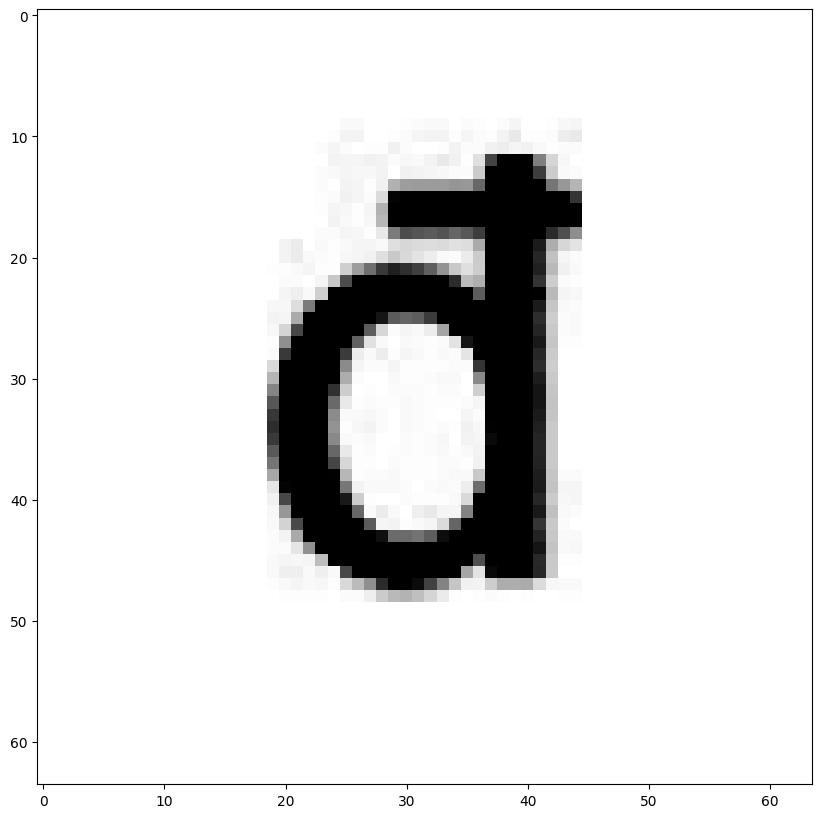

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 20))
plt.imshow(pixel_values[10].cpu().permute(1,2,0).numpy()) #3,64,640